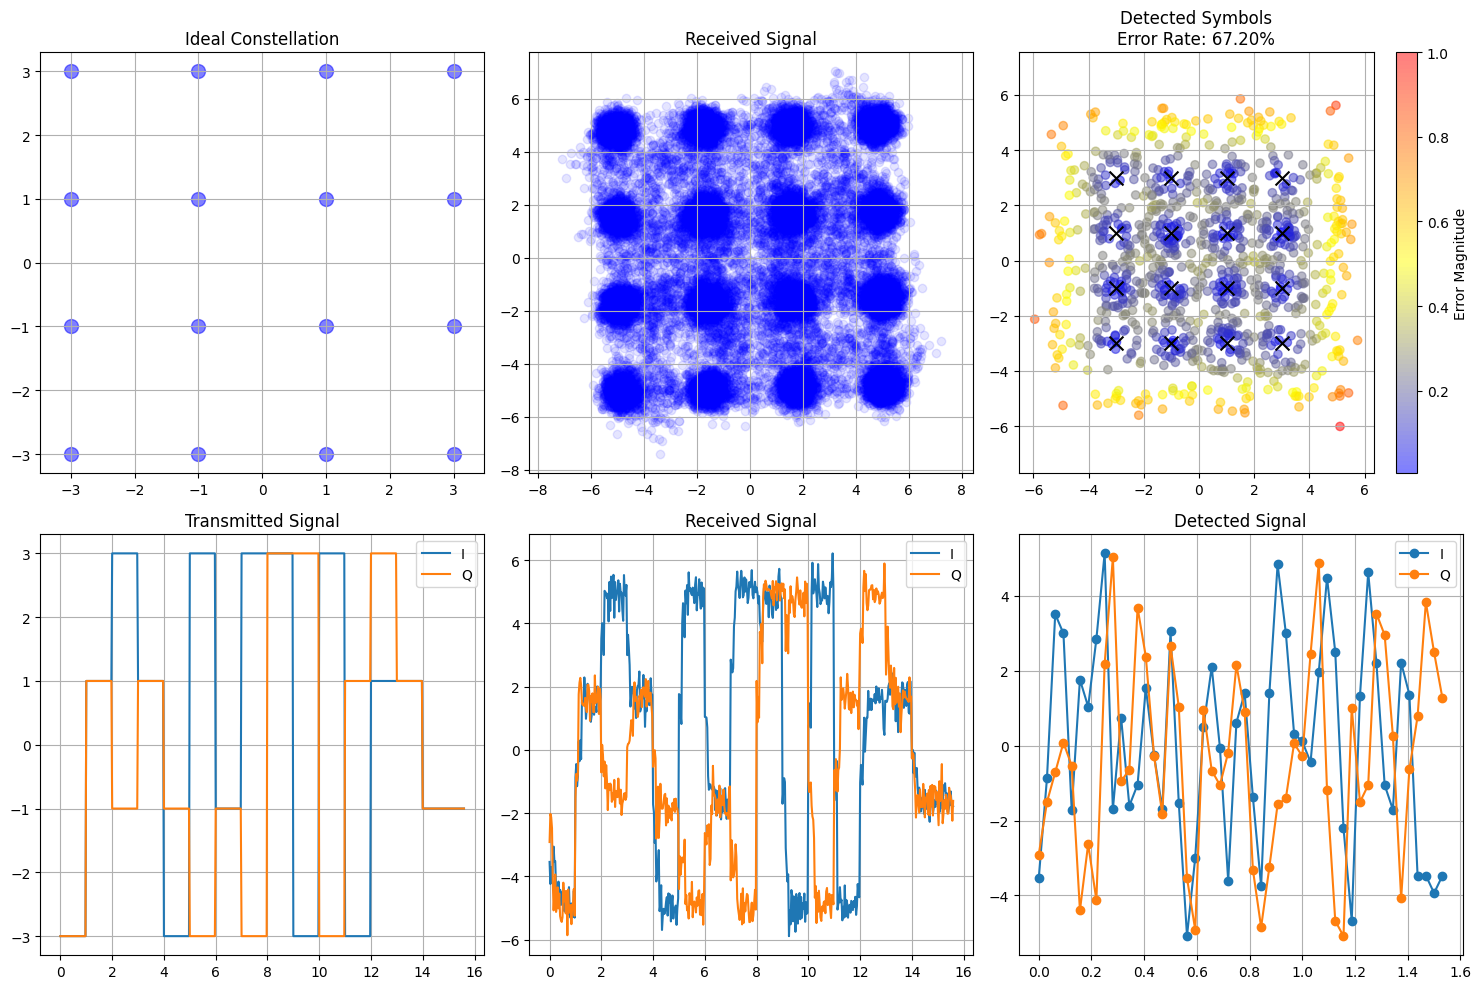

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def generate_16qam_symbols(num_symbols):
    real_parts = np.array([-3, -1, 1, 3])
    constellation = np.array([x + 1j*y for x in real_parts for y in real_parts])
    symbol_indices = np.random.randint(0, 16, num_symbols)
    return constellation[symbol_indices], constellation, symbol_indices

def multipath_channel(signal, delays, gains, snr_db):
    output = np.zeros_like(signal, dtype=complex)
    for delay, gain in zip(delays, gains):
        delayed_signal = np.roll(signal, delay)
        output += gain * delayed_signal

    signal_power = np.mean(np.abs(output)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(signal)) +
                                    1j*np.random.randn(len(signal)))
    return output + noise

def find_nearest_symbol(received, constellation):
    distances = np.abs(received.reshape(-1, 1) - constellation.reshape(1, -1))
    nearest_indices = np.argmin(distances, axis=1)
    error_magnitudes = np.min(distances, axis=1)
    return nearest_indices, error_magnitudes

# Simulation parameters
num_symbols = 1000
samples_per_symbol = 32
t = np.arange(num_symbols * samples_per_symbol) / samples_per_symbol

# Generate QAM symbols and upsample
symbols, constellation, original_indices = generate_16qam_symbols(num_symbols)
tx_signal = np.repeat(symbols, samples_per_symbol)

# Channel parameters
delays = [0, 4, 8]
gains = [1, 0.5*np.exp(1j*np.pi/6), 0.3*np.exp(-1j*np.pi/4)]
snr_db = 20

# Pass through channel
rx_signal = multipath_channel(tx_signal, delays, gains, snr_db)

# Coherent detection
t_sample = np.arange(num_symbols) * samples_per_symbol
detected_symbols = rx_signal[t_sample]

# Find detection errors
detected_indices, error_magnitudes = find_nearest_symbol(detected_symbols, constellation)
detection_errors = detected_indices != original_indices

# Create custom colormap
colors = ['blue', 'yellow', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Normalize error magnitudes for coloring
max_error = np.max(error_magnitudes)
normalized_errors = error_magnitudes / max_error

plt.figure(figsize=(15, 10))

# IQ diagrams
plt.subplot(231)
plt.scatter(constellation.real, constellation.imag, c='blue', s=100, alpha=0.5)
plt.title('Ideal Constellation')
plt.grid(True)
plt.axis('equal')

plt.subplot(232)
plt.scatter(rx_signal.real, rx_signal.imag, alpha=0.1, c='blue')
plt.title('Received Signal')
plt.grid(True)
plt.axis('equal')

plt.subplot(233)
scatter = plt.scatter(detected_symbols.real, detected_symbols.imag,
                     c=normalized_errors, cmap=cmap, alpha=0.5)
plt.colorbar(scatter, label='Error Magnitude')
plt.scatter(constellation.real, constellation.imag, c='black', marker='x', s=100)
plt.title(f'Detected Symbols\nError Rate: {np.mean(detection_errors):.2%}')
plt.grid(True)
plt.axis('equal')

# Time domain plots
t_plot = t[:500]
plt.subplot(234)
plt.plot(t_plot, tx_signal[:500].real, label='I')
plt.plot(t_plot, tx_signal[:500].imag, label='Q')
plt.title('Transmitted Signal')
plt.legend()
plt.grid(True)

plt.subplot(235)
plt.plot(t_plot, rx_signal[:500].real, label='I')
plt.plot(t_plot, rx_signal[:500].imag, label='Q')
plt.title('Received Signal')
plt.legend()
plt.grid(True)

plt.subplot(236)
plt.plot(t[:50], detected_symbols[:50].real, 'o-', label='I')
plt.plot(t[:50], detected_symbols[:50].imag, 'o-', label='Q')
plt.title('Detected Signal')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

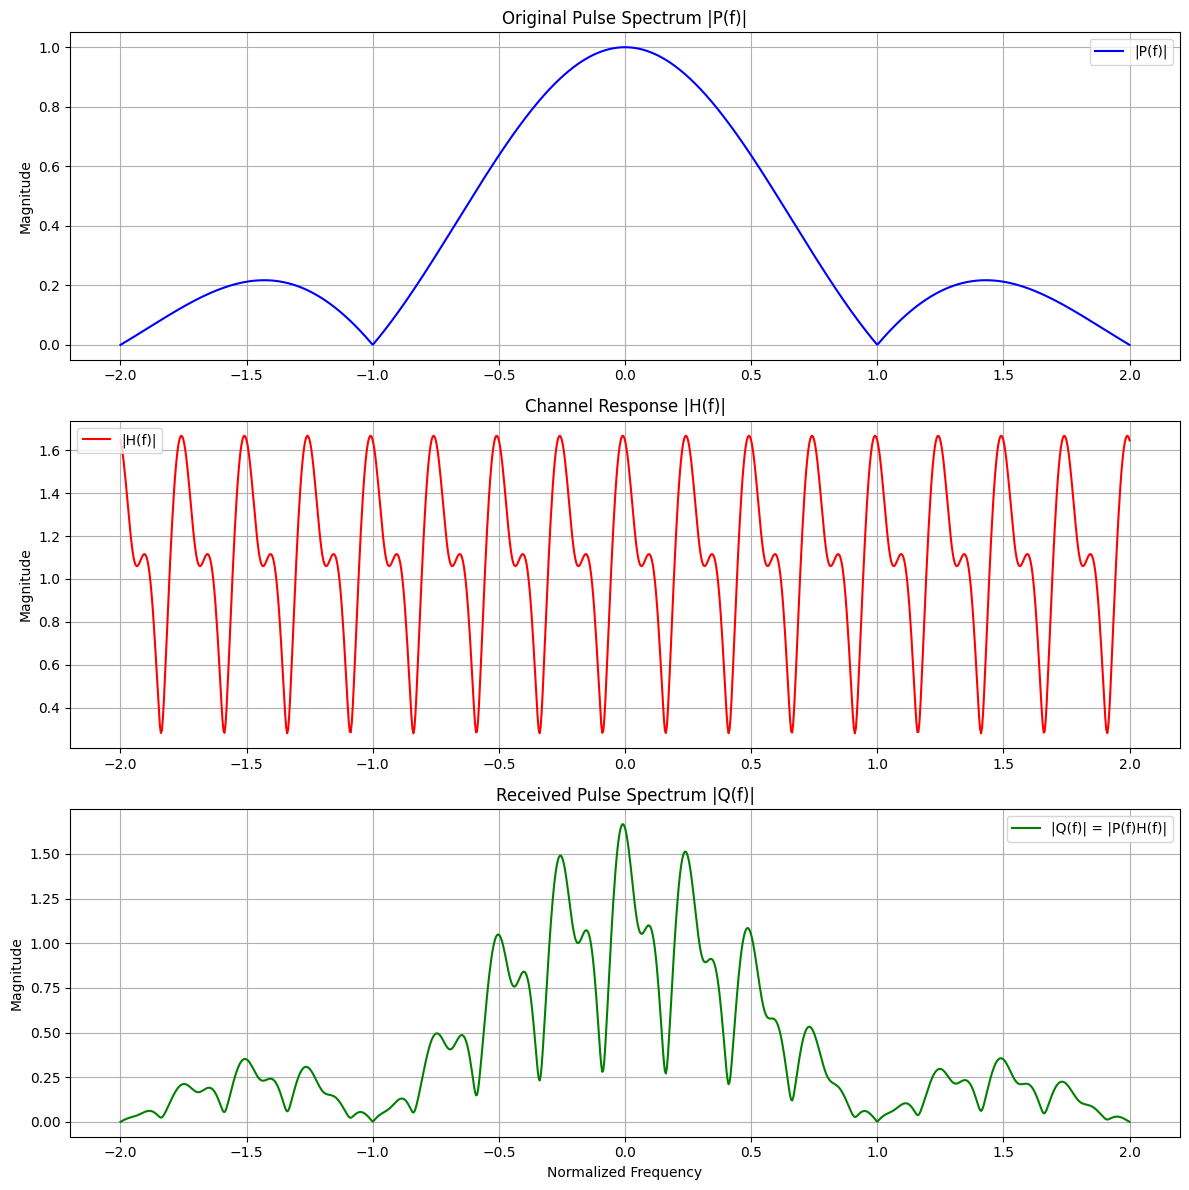

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def rect_pulse_spectrum(f, T):
    return T * np.sinc(f * T)

def channel_response(f, delays, gains, wc):
    H = np.zeros(len(f), dtype=complex)
    for i, (delay, gain) in enumerate(zip(delays, gains)):
        H += gain * np.exp(-1j * (2*np.pi*f - wc) * delay)
    return H

# Parameters
T = 1
f = np.linspace(-2, 2, 1000)
delays = [0, 4, 8]
gains = [1, 0.5*np.exp(1j*np.pi/6), 0.3*np.exp(-1j*np.pi/4)]
wc = 2*np.pi*0.25

# Calculate spectra
P = rect_pulse_spectrum(f, T)
H = channel_response(f, delays, gains, wc)
Q = P * H

plt.figure(figsize=(12, 12))

# Magnitude responses
plt.subplot(3, 1, 1)
plt.plot(f, np.abs(P), 'b-', label='|P(f)|')
plt.grid(True)
plt.title('Original Pulse Spectrum |P(f)|')
plt.ylabel('Magnitude')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(f, np.abs(H), 'r-', label='|H(f)|')
plt.grid(True)
plt.title('Channel Response |H(f)|')
plt.ylabel('Magnitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(f, np.abs(Q), 'g-', label='|Q(f)| = |P(f)H(f)|')
plt.grid(True)
plt.title('Received Pulse Spectrum |Q(f)|')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude')
plt.legend()

plt.tight_layout()
plt.show()